In [42]:
!pip  install -r ./requirements.txt

In [10]:
%load_ext autoreload
%autoreload 2
import se2_flow
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


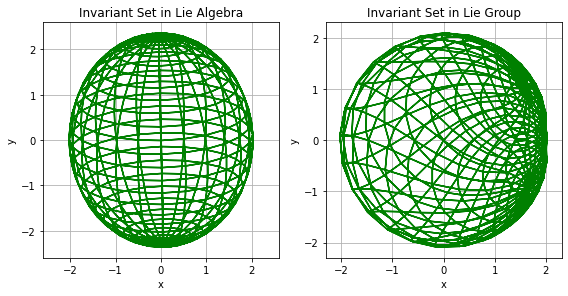

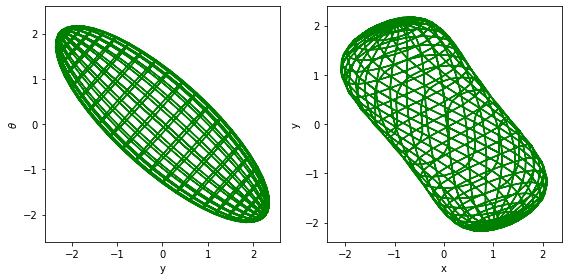

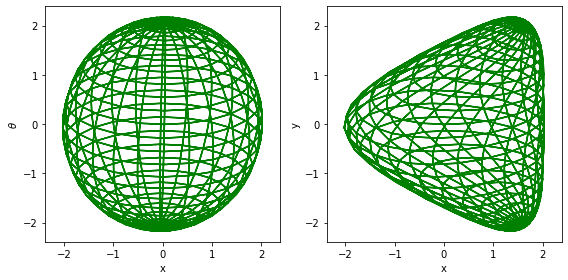

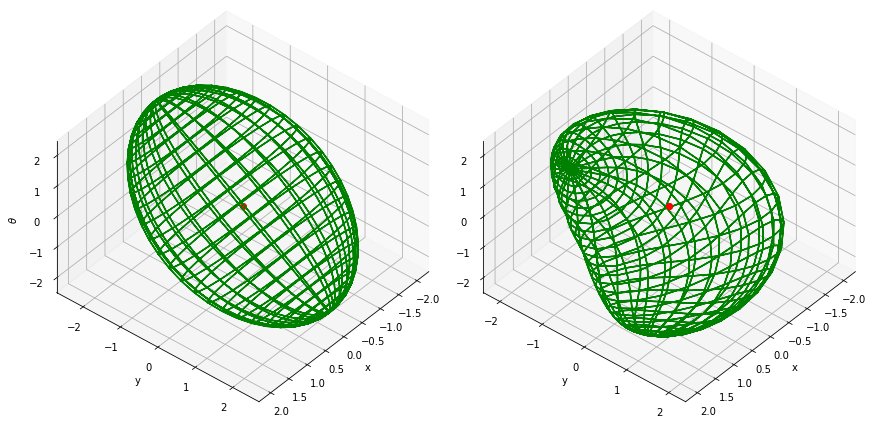

In [11]:
sol = se2_flow.find_se2_invariant_set()
se2_flow.plot_invariant_set(sol, w1=1, w2=1)

In [12]:
sol

{'cost': 9.274897920965127,
 'prob': <Semidefinite Program>,
 'mu1': 7.903660881828132,
 'mu2': 1.3712370391369957,
 'P': array([[ 2.26 , -0.07 , -0.111],
        [-0.07 ,  4.563,  3.958],
        [-0.111,  3.958,  5.399]]),
 'alpha': (0.8673457038863507+0j),
 'gam': <1×1 Real Linear Expression: mu_1 + mu_2>}

# Flow Pipes Simulation

In [13]:
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol1 = se2_flow.find_se2_invariant_set() # u, v, w1, w2

ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e0 = se2_flow.se2_log(np.array([0, 0, -np.pi/10]))

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)

#TEB_small = circ_inv(1.476) # HJB w/ control bound [-pi,pi]
#L_small = circ_inv(1.4487) # lyapunov w/ small theta_max
#L_large = circ_inv(2.1136) # lyapunov w/ large theta_max
#flow_pipes_Ls, intervalhull_Ls, nom, ang = flowpipes(res,L_small,t, n)
#flow_pipes_Ll, intervalhull_Ll, nom = flowpipes(xr,r_large,t, n)
#flow_pipes_Hs, intervalhull_Hs, nom, ang = flowpipes(res,TEB_small,t, n)
#flow_pipes_Hl, intervalhull_Hl, nom = flowpipes(xr,TEB,t, n)

Text(0, 0.5, 'y')

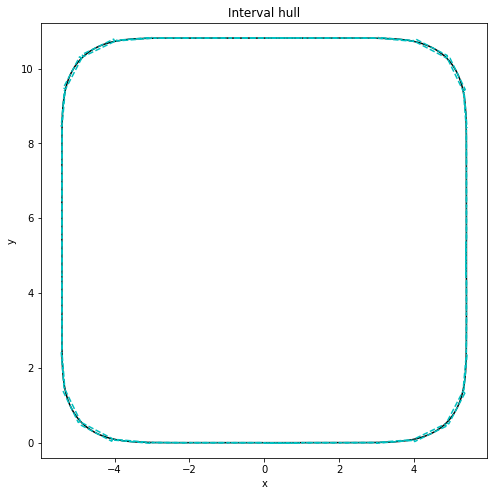

In [14]:
# interval hull
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_Ls = ax.plot(intervalhull_Ls[facet][:,0], intervalhull_Ls[facet][:,1], color='m', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Interval hull')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_Ls[0]], ['nominal', 'interval hull'], loc=1);

Text(0, 0.5, 'y')

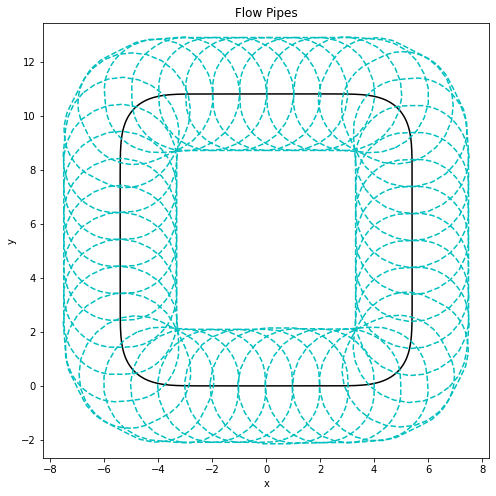

In [15]:
# flow pipes
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Flow Pipes')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

# Trajectories simulation

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


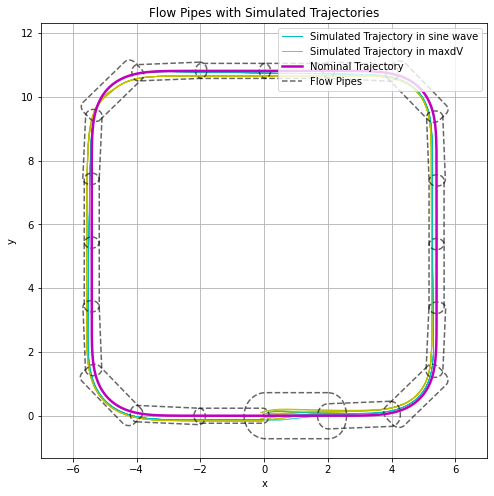

In [16]:
# small distrubance
freq = [0.02] #, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 20 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e = []
V=[]

for theta0 in np.linspace(-np.pi/10, np.pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = np.array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        se2_flow.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        se2_flow.plot_simulated(r2, name='maxdV', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        se2_flow.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        se2_flow.plot_simulated(r2, name='', legend=False, save=False, linewidth = 1, color = 'y')
                        
i = np.array(V).argmax()
print(e[i])
e0 = se2_flow.se2_log(np.array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 2.5)

plt.axis('equal')
plt.xlim([-7, 7])
plt.ylim([-3, 14])
plt.title('Flow Pipes with Simulated Trajectories')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[ 0.          0.         -0.31415927]


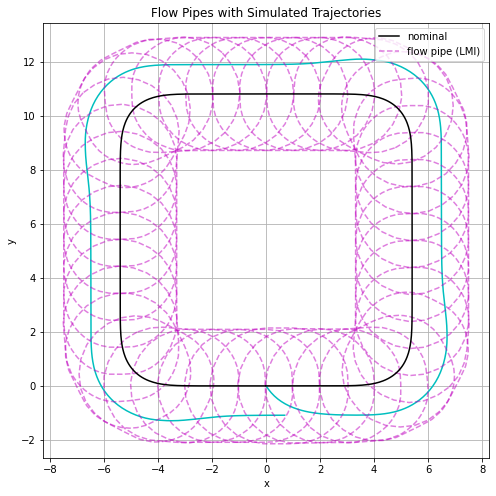

In [17]:
# large disturbance
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
freq = [0.02]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


init_e = np.array([[0, 0, -np.pi/10]]).T 
V0 = init_e.T@sol['P']@init_e
for i in freq:
    r = se2_flow.simulate(tf=40, freq_d=i, w1_mag=w1, w2_mag=w2, x0=init_e[0], y0=init_e[1], theta0=init_e[2], dist='maxdV', sol= sol1, use_approx=False)
    se2_flow.plot_simulated(r, color='c', name='sine wave', legend=True, save=False)
    res.append(r)
                
e0 = se2_flow.se2_log(init_e.reshape(3,))
print(e0)
flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='m', linestyle='--', alpha = 0.5)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='k', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes with Simulated Trajectories')
plt.xlabel('x')
plt.ylabel('y')
plt.legend([h_nom[0], hs_ch_LMI[0]], ['nominal', 'flow pipe (LMI)'], loc=1);

# Application Example

In [18]:
V2 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])
P2 = se2_flow.Polytope(V2)
p4 = (4, 6)
P3 = P2*1.5 + (0,8.5)
P4 = P2 + p4
rot_mat5 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                     [np.sin(np.pi/4), np.cos(np.pi/4)]])
P5 = 0.5*rot_mat5*P3 -(1, 0)

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


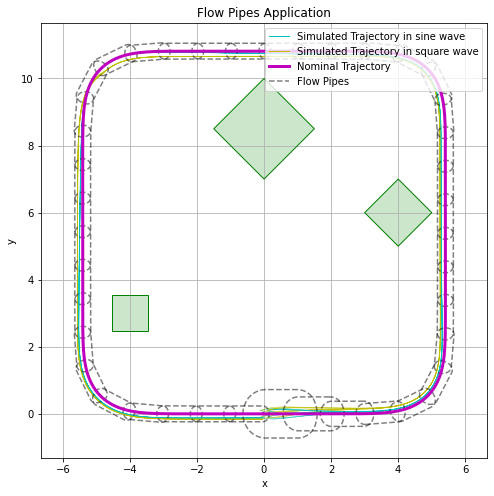

In [19]:
#freq = [0.02, .04, .06, .08, .01]
freq = [0.02]

res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


for theta0 in np.linspace(-np.pi/10, np.pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = np.array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        se2_flow.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        se2_flow.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        se2_flow.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        se2_flow.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y')
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_flow.se2_log(np.array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.5)

P4.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 3)

plt.axis('equal')
plt.title('Flow Pipes Application')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[ 1.        ]
 [-1.        ]
 [-3.14159265]]
[ 1.57079633  1.57079633 -3.14159265]


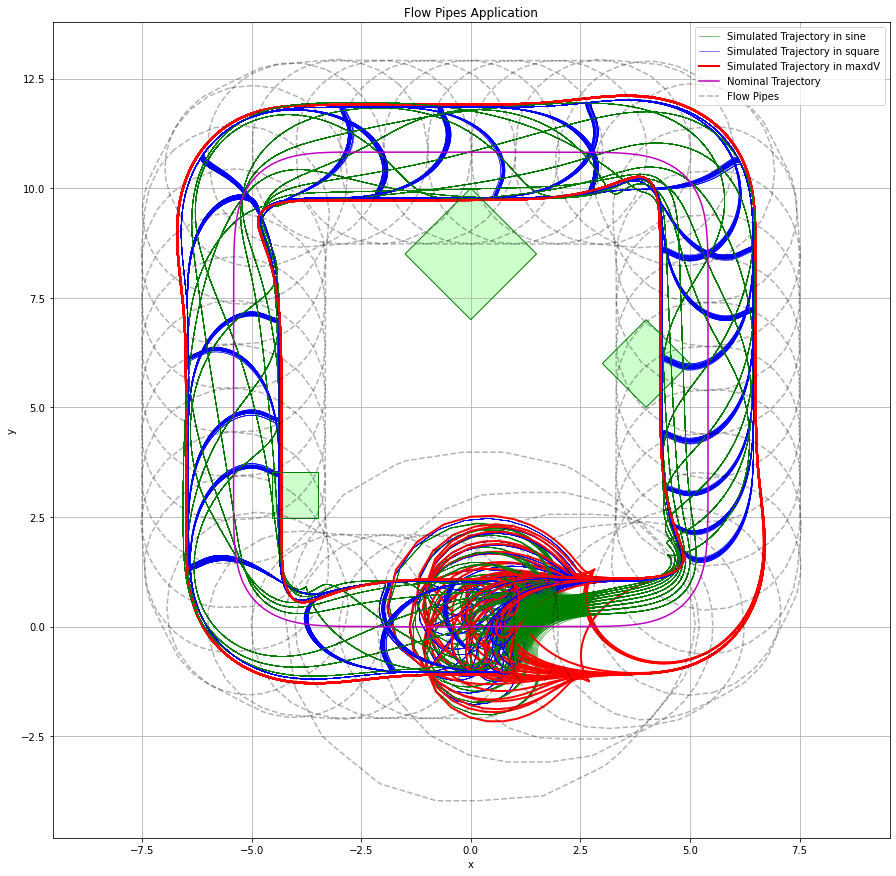

In [41]:
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
plt.figure(figsize=(15, 15))

e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1
ref = se2_flow.simulate(t, 0, 0, 0, 0, 0, 0, dist='none', sol= sol1, use_approx=False)

cnt = 0
for theta0 in np.arange(-np.pi, np.pi, np.pi/4):
    for x0 in np.linspace(-1, 1, 3):
        for y0 in np.linspace(-1, 1, 3):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                r = se2_flow.simulate(t, f, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                r2 = se2_flow.simulate(t, f, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                legend = cnt == 1 and i == 0
                se2_flow.plot_simulated(r, name='sine', legend=legend, save=False, linewidth = .5, color = 'g', alpha = 1)
                se2_flow.plot_simulated(r2, name='square', legend=legend, save=False, linewidth = .5, color = 'b', alpha = 1)
                
                # want to draw last so it is on top
                if i == len(freq) - 1:
                    r3 = se2_flow.simulate(t, f, w1, w2, x0, y0, theta0, dist='maxdV', sol= sol1, use_approx=False)
                    se2_flow.plot_simulated(r3, name='maxdV', legend=(cnt==1), save=False, linewidth = 2, color = 'r', alpha = 1)
        
i = np.array(V).argmax()
print(e[i])
e0 = se2_flow.se2_log(np.array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.3)

P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/maxdV.png')

In [21]:
n2 = 40
points = se2_flow.se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra

exp_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points[:,i] = se2_flow.SE2_exp_wedge(points[:,i])
flow_pipes3d_s, intervalhull_s, nom = se2_flow.flowpipes3d(ref,exp_points,t, n2)

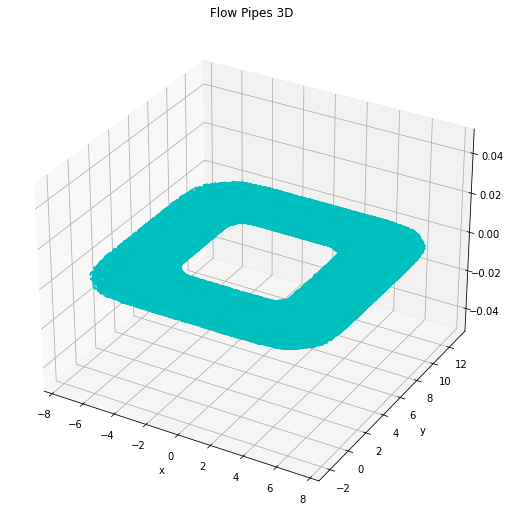

In [22]:
plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n2):
    hs_ch_s = ax.plot3D(flow_pipes3d_s[facet][:,0], flow_pipes3d_s[facet][:,1], color='c', linestyle='--')

plt.title('Flow Pipes 3D')
plt.xlabel('x')
plt.ylabel('y');